In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import scipy.stats as stats
from bioinfokit.analys import stat
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random

In [268]:
covid_df = pd.read_csv('./data/owid-covid-data.csv')
covid_df = covid_df[['continent', 'location', 'date', 'total_cases',  'new_cases', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths', 'new_deaths', 'total_deaths_per_million', 'new_deaths_per_million', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred', 'population']]
covid_df.columns = ['Continent', 'Location', 'Date', 'TotalCases',  'NewCases', 'TotalCases_per_million', 'NewCases_per_million', 'TotalDeaths', 'NewDeaths', 'TotalDeaths_per_million', 'NewDeaths_per_million', 'TotalVaccinations', 'PeopleVaccinated', 'PeopleFullyVaccinated', 'PeopleFullyVaccinated_per_hundred', 'Population']
covid_df = covid_df[~covid_df['Population'].isna()]
covid_df = covid_df.replace('', np.nan).fillna(0)
covid_world_df = covid_df[covid_df.Location == 'World']
print(f"Dữ liệu về dịch bệnh Covid-19 được thu thập từ ngày {covid_world_df.Date.min()} tới ngày {covid_world_df.Date.max()}")

Dữ liệu về dịch bệnh Covid-19 được thu thập từ ngày 2020-01-22 tới ngày 2022-03-05


## Câu 1: Số ca mắc Covid-19 có phụ thuộc vào các châu lục khi bùng phát hay không ? **(X: Continent, Total Cases)**  **(Y: True/False)**

<font face="Cambria Math" size=5 color = #1155cc> Quan hệ 𝐶 → 𝑄: nhiều nhóm độc lập </font>

*  <font face="Cambria Math" size=4> Với 𝐶: Biến Continent (Biến catagorical) </font>
* <font face="Cambria Math" size=4>  Với 𝑄: Biến TotalCases (Biến quantitative)</font>

Tổng số ca mắc Covid-19 theo từng khu vực trên thế giới

In [269]:
covid_country = covid_df.copy()
covid_country = covid_country.groupby(by='Location').agg({'Location' : 'first','Continent' : 'first', 'TotalCases': 'max'})

In [270]:
covid_continent = covid_country.groupby(by = 'Continent').agg({'Continent' : 'first', 'TotalCases': 'sum'})
covid_continent = covid_continent[covid_continent.Continent != 0]
covid_continent

,Continent,TotalCases
Continent,,
Africa,Africa,11272358.0
Asia,Asia,120758420.0
Europe,Europe,161250675.0
North America,North America,93398426.0
Oceania,Oceania,3831683.0
South America,South America,54622339.0


Biểu đồ tổng quan về số ca mắc ở các khu vực

In [271]:
def plot_pie(df, values, names, title):
    fig = px.pie(df, values=values, names=names, title=title)
    fig.show()

In [272]:
def plot_bar(df, x, y, title):
    figure = px.bar(df, x = x, y = y, color = 'Continent', text = x, orientation='h', height=500,
                    color_discrete_sequence = px.colors.qualitative.Dark2)
    figure.update_layout(title=title, xaxis_title=x, yaxis_title=y, 
                    yaxis_categoryorder = 'total ascending',
                    uniformtext_minsize=8, uniformtext_mode='hide')
    figure.show()

In [273]:
#plot_bar(covid_continent, "TotalCases", "Continent", "Tổng số ca mắc Covid-19 theo từng khu vực")
plot_pie(covid_continent,"TotalCases", "Continent", "Tổng số ca mắc Covid-19 theo từng khu vực")

Thông qua biểu đồ trực quan hoá, ta cũng có thể nhận thấy số ca mắc Covid-19 giữa các châu lục khác nhau đều có sự khác nhau. Để có thể kết luận, ta sẽ thực hiện phép thống kê giữa hai biến Continent (catagorical) và biến TotalCases (quantitative) để có thể đưa ra nhận xét. 

In [274]:
def get_value_series(col, continent):
    df = covid_country.loc[covid_country["Continent"] == continent]
    case_per_country = list([])
    for value in df[col]:
        case_per_country.append(value)
    return pd.Series(case_per_country)

In [275]:
continents = covid_country[covid_country["Continent"] != 0]["Continent"].unique()
dict = {}
for continent in continents:
    serie_values = get_value_series("TotalCases", continent)
    dict[continent] = serie_values
case_per_continent = pd.DataFrame(dict)
df_melt = pd.melt(case_per_continent.reset_index(), id_vars=['index'], value_vars=continents)
df_melt.columns = ['index', 'Continent', 'TotalCases']
df_melt

,index,Continent,TotalCases
0,0,Asia,174331.0
1,1,Asia,421226.0
2,2,Asia,788958.0
3,3,Asia,525171.0
4,4,Asia,1946737.0
...,...,...,...
325,50,Oceania,NaN
326,51,Oceania,NaN
327,52,Oceania,NaN
328,53,Oceania,NaN


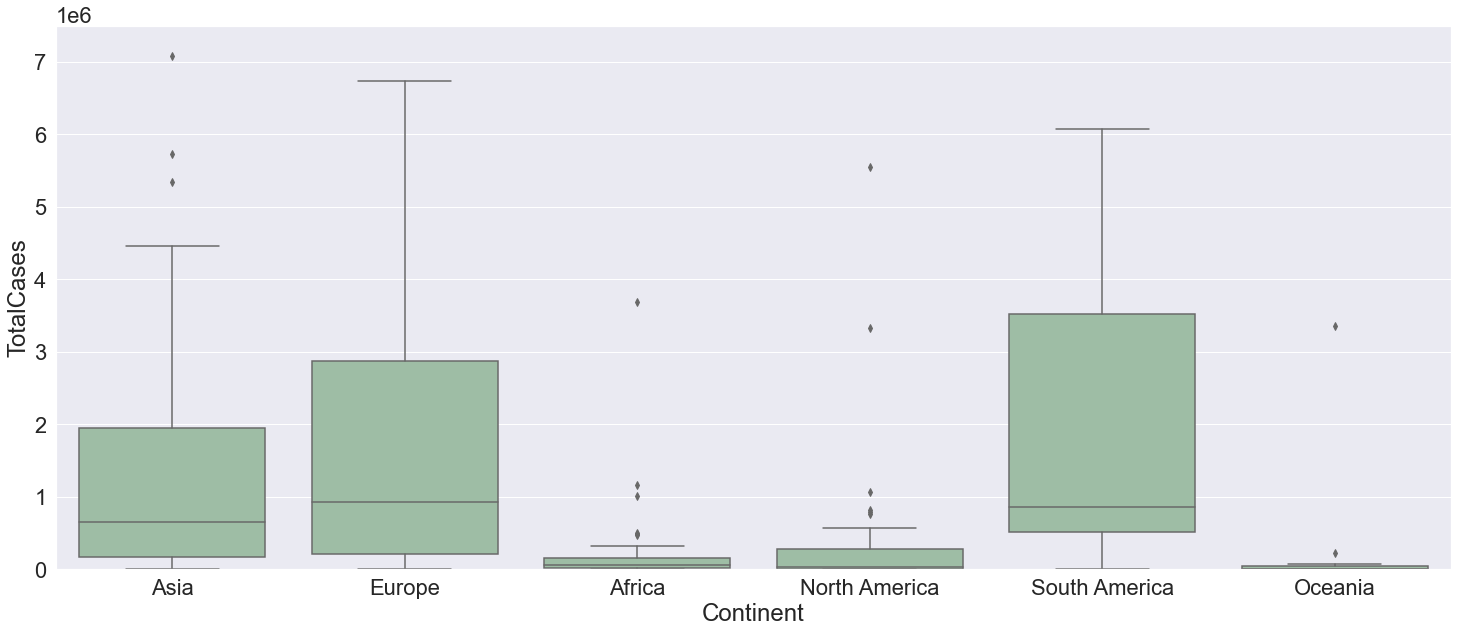

In [276]:
sns.set(rc = {'figure.figsize':(25,10)})
sns.set(font_scale = 2)
ax = sns.boxplot(x='Continent', y='TotalCases', data=df_melt, color='#99c2a2')
ax.set(ylim=(0, 7500000))
plt.show()

Thực hiện thống kê ANOVA F-test

In [277]:
res = stat()
res.anova_stat(df=df_melt, res_var='TotalCases', anova_model='TotalCases ~ C(Continent)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Continent),5.0,4.046238e+14,8.092477e+13,1.720232,0.131053
Residual,218.0,1.025536e+16,4.704295e+13,NaN,NaN


<font face="Cambria Math" size=4 face="black body"> Gọi H0: Số ca mắc Covid-19 trung bình giữa các khu vực như nhau</font>

<font face="Cambria Math" size=4 face="black body"> Gọi Ha: Số ca mắc Covid-19 trung bình giữa các khu vực có sự khác nhau</font>

<font face="Cambria Math" size=4 color = #a61c00> Ta có P-value = 0.131053 thông qua phép thống kê ANOVA F-test </font>

<font face="Cambria Math" size=6 face="black body"> Nhận xét </font>

<font face="Cambria Math" size=4 face="black body">Ta có: P-value = 0.131053 > 0.05 → Ta chấp nhận H0, giữa hai biến Continent và TotalCases không có mối quan hệ. Sự bùng phát dịch bệnh Covid-19 có lẽ đều có thể xảy ra mà không phân biệt châu lục nào.</br>Hơn nữa, vì ta thực hiện phép thống kê ANOVA F-test trên các nhóm dữ
liệu không đồng đều (Số nước của mỗi châu lục là khác nhau và số ca mắc giữa các nước cũng có sự chênh lệch), điều đó có thể giảm độ chính xác của phép thống kê.</font>

## Câu 3: Dân số có phải là nguyên nhân dẫn tới việc gia tăng số ca mắc ở các nước châu Á ? **(X: Location, Population, TotalCases)**  **(Y: Số ca mắc)**

<font face="Cambria Math" size=5 color = #1155cc> Quan hệ 𝑄 → 𝑄 </font>

*  <font face="Cambria Math" size=4> Với Q: Biến Population (Biến quantitative) </font>
* <font face="Cambria Math" size=4>  Với 𝑄: Biến TotalCases (Biến quantitative)</font>

In [278]:
covid_country = covid_df.copy()
population_country = covid_country.groupby(by = 'Location').agg({'Continent' : 'first', 'Population': 'max'})
population_country = population_country.groupby(by = "Continent").agg({'Continent' : 'first', 'Population': 'sum'})
population_country = population_country[population_country.Continent != 0]
population_country

,Continent,Population
Continent,,
Africa,Africa,1.371693e+09
Asia,Asia,4.652616e+09
Europe,Europe,7.506718e+08
North America,North America,5.928348e+08
Oceania,Oceania,4.320246e+07
South America,South America,4.339537e+08


In [279]:
plot_bar(population_country, "Population", "Continent", "Dân số theo khu vực trên thế giới")

Từ biểu đồ trên, ta có thể thấy châu Á là châu lục có số dân đông nhất thế giới, vượt xa các châu lục khác. 

Châu Á là nơi dự đoán có thể có số ca mắc Covid-19 nhiều nhất trên thế giới do dân số đông. 

Ta cùng thực hiện phép thông kê để kiểm chứng liệu dân số đông có phải là nguyên nhân dẫn tới gia tăng số ca mắc hay không ?

In [280]:
cases_country = covid_country.groupby(by = 'Location').agg({'Continent' : 'first','Location' : 'first', 'TotalCases': 'max', 'Population': 'max'})
cases_country = cases_country[cases_country["Continent"] != 0]
cases_Asia = cases_country.loc[cases_country['Continent'] == "Asia"]
cases_Asia.head()

,Continent,Location,TotalCases,Population
Location,,,,
Afghanistan,Asia,Afghanistan,174331.0,39835428.0
Armenia,Asia,Armenia,421226.0,2968128.0
Azerbaijan,Asia,Azerbaijan,788958.0,10223344.0
Bahrain,Asia,Bahrain,525171.0,1748295.0
Bangladesh,Asia,Bangladesh,1946737.0,166303494.0


In [281]:
fig = px.scatter(cases_Asia, x="Population", y="TotalCases", color = "TotalCases",
                 size='TotalCases', hover_name= "Location", title="Biểu đồ thể hiện sự tương quan giữa dân số và số ca mắc ở các nước châu Á")
fig.show()


***Tính hệ số tương quan để xem mối quan hệ giữa hai biến***

In [282]:
R = np.corrcoef(cases_Asia["Population"], cases_Asia["TotalCases"])
R

array([[1.        , 0.63340569],
       [0.63340569, 1.        ]])

Theo biểu đồ, ta thấy có 2 giá trị ngoại lai ứng với 2 nước là Trung Quốc và Ấn Độ.

Trung Quốc là nước đông dân nhất thế giới, đồng thời là nơi khởi nguồn của dịch bệnh nhưng số ca mắc Covid-19 ở nước này lại không cao. 

Còn trường hợp là Ấn Độ, nước có dân số đông chỉ sau Trung Quốc và số ca mắc cũng tăng nhanh.

Ta thử bỏ điểm dữ liệu này để xem sự khác biệt về hệ số tương quan
 

In [283]:
cases_Asia = cases_Asia.loc[cases_Asia['Location'] != "India"]
cases_Asia = cases_Asia.loc[cases_Asia['Location'] != "China"]

In [284]:
fig = px.scatter(cases_Asia, x="Population", y="TotalCases", color = "TotalCases",
                 size='TotalCases', hover_name= "Location", title="Biểu đồ thể hiện sự tương quan giữa dân số và số ca mắc ở các nước châu Á", trendline="ols")
fig.show()

***Tính lại hệ số tương quan và khớp đường thẳng tuyến tính***

In [285]:
R = np.corrcoef(cases_Asia["Population"], cases_Asia["TotalCases"])
R

array([[1.       , 0.5008545],
       [0.5008545, 1.       ]])

Ta thấy hệ số tương quan giảm so với lúc trước khi bỏ hai giá trị ngoại lai

**Ta đặt giả thuyết thống kê**

H0: Hai biến không có mối quan hệ tuyến tính

H1: Hai biến có mối quan hệ tuyến tính

In [286]:
slope, intercept, r_value, p_value, std_err = stats.linregress(cases_Asia["Population"], cases_Asia["TotalCases"])
p_value

0.0003362358195896713

In [303]:
print(f"Ta tính được giá trị P-value = {p_value} < 0.05")
print(f"Ta bác bỏ H0, chấp nhận H1")


Ta tính được giá trị P-value = 0.0003362358195896713 < 0.05
Ta bác bỏ H0, chấp nhận H1


Tuy nhiên, vì hệ số tương quan R = 0.5 không quá mạnh cũng không quá yếu, ta cũng chưa thể kết luận ngay dân số có ảnh hưởng đến số ca mắc Covid-19 hay không vì còn nhiều yếu tố ảnh hưởng khác như hệ thống y tế, chính sách cách ly của mỗi quốc gia...

## Câu 4: Khi vaccine được phổ biến, điều đó có giúp ích cho việc chống đại dịch Covid-19 trên thế giới? **(X: Date, PeopleFullyVaccinated, NewCases, NewDeaths)**  **(Y: True/False)**

Dữ liệu Covide-19 trên thế giới

In [287]:
covid_world_df

,Continent,Location,Date,TotalCases,NewCases,TotalCases_per_million,NewCases_per_million,TotalDeaths,NewDeaths,TotalDeaths_per_million,NewDeaths_per_million,TotalVaccinations,PeopleVaccinated,PeopleFullyVaccinated,PeopleFullyVaccinated_per_hundred,Population
163423,0,World,2020-01-22,557.0,0.0,0.071,0.000,17.0,0.0,0.002,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.00,7.874966e+09
163424,0,World,2020-01-23,657.0,100.0,0.083,0.013,18.0,1.0,0.002,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.00,7.874966e+09
163425,0,World,2020-01-24,944.0,287.0,0.120,0.036,26.0,8.0,0.003,0.001,0.000000e+00,0.000000e+00,0.000000e+00,0.00,7.874966e+09
163426,0,World,2020-01-25,1437.0,493.0,0.182,0.063,42.0,16.0,0.005,0.002,0.000000e+00,0.000000e+00,0.000000e+00,0.00,7.874966e+09
163427,0,World,2020-01-26,2120.0,683.0,0.269,0.087,56.0,14.0,0.007,0.002,0.000000e+00,0.000000e+00,0.000000e+00,0.00,7.874966e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164192,0,World,2022-03-01,438528632.0,1536867.0,55686.418,195.159,5964706.0,8069.0,757.426,1.025,1.072498e+10,4.971171e+09,4.385303e+09,55.69,7.874966e+09
164193,0,World,2022-03-02,440180084.0,1651452.0,55896.127,209.709,5972651.0,7945.0,758.435,1.009,1.073855e+10,4.972139e+09,4.387583e+09,55.72,7.874966e+09
164194,0,World,2022-03-03,442067549.0,1887465.0,56135.806,239.679,5981034.0,8384.0,759.500,1.065,1.075182e+10,4.973141e+09,4.393034e+09,55.78,7.874966e+09
164195,0,World,2022-03-04,443767689.0,1704138.0,56351.698,216.399,5989802.0,8771.0,760.613,1.114,1.076247e+10,4.974734e+09,4.396314e+09,55.83,7.874966e+09


In [288]:
first_date_vaccine = covid_world_df[covid_world_df['TotalVaccinations'] != 0].iloc[0]['Date']
print(f"Vaccine được đưa vào sử dụng đầu tiên vào ngày {first_date_vaccine}")

Vaccine được đưa vào sử dụng đầu tiên vào ngày 2020-12-04


In [289]:
covid_world_after_vaccine = covid_world_df[covid_world_df['Date'] >= first_date_vaccine]
covid_world_after_vaccine

,Continent,Location,Date,TotalCases,NewCases,TotalCases_per_million,NewCases_per_million,TotalDeaths,NewDeaths,TotalDeaths_per_million,NewDeaths_per_million,TotalVaccinations,PeopleVaccinated,PeopleFullyVaccinated,PeopleFullyVaccinated_per_hundred,Population
163740,0,World,2020-12-04,66049040.0,688697.0,8387.216,87.454,1576378.0,12460.0,200.176,1.582,1.000000e+00,1.000000e+00,0.000000e+00,0.00,7.874966e+09
163741,0,World,2020-12-05,66697974.0,648934.0,8469.621,82.405,1586715.0,10337.0,201.488,1.313,1.000000e+00,1.000000e+00,0.000000e+00,0.00,7.874966e+09
163742,0,World,2020-12-06,67234273.0,536299.0,8537.723,68.102,1594444.0,7729.0,202.470,0.981,1.000000e+00,1.000000e+00,0.000000e+00,0.00,7.874966e+09
163743,0,World,2020-12-07,67761913.0,527640.0,8604.725,67.002,1603158.0,8714.0,203.577,1.107,2.000000e+00,2.000000e+00,0.000000e+00,0.00,7.874966e+09
163744,0,World,2020-12-08,68405171.0,643258.0,8686.409,81.684,1615473.0,12317.0,205.140,1.564,8.000000e+00,8.000000e+00,0.000000e+00,0.00,7.874966e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164192,0,World,2022-03-01,438528632.0,1536867.0,55686.418,195.159,5964706.0,8069.0,757.426,1.025,1.072498e+10,4.971171e+09,4.385303e+09,55.69,7.874966e+09
164193,0,World,2022-03-02,440180084.0,1651452.0,55896.127,209.709,5972651.0,7945.0,758.435,1.009,1.073855e+10,4.972139e+09,4.387583e+09,55.72,7.874966e+09
164194,0,World,2022-03-03,442067549.0,1887465.0,56135.806,239.679,5981034.0,8384.0,759.500,1.065,1.075182e+10,4.973141e+09,4.393034e+09,55.78,7.874966e+09
164195,0,World,2022-03-04,443767689.0,1704138.0,56351.698,216.399,5989802.0,8771.0,760.613,1.114,1.076247e+10,4.974734e+09,4.396314e+09,55.83,7.874966e+09


In [290]:
fig = px.scatter(covid_world_after_vaccine, x="PeopleFullyVaccinated", y="NewCases",trendline="ols", hover_name="Date", title="Biểu đồ thể hiện sự tương quan giữa tổng số người tiêm đủ liều vaccine và số ca mắc mới mỗi ngày trên thế giới")
fig.show()

In [291]:
R = np.corrcoef(covid_world_after_vaccine["PeopleFullyVaccinated"], covid_world_after_vaccine["NewCases"])
R

array([[1.        , 0.57672504],
       [0.57672504, 1.        ]])

Ta có thể thấy số ca mắc mới mỗi ngàu vẫn tăng khi số lượng người thực hiện tiêm đầy đủ vaccine tăng lên. 

Tuy nhiên, để đánh giá mức độ giúp ích của vaccine, ta hãy xét về số ca tử vong mỗi ngày sau khi tiến hành tiêm vaccine

In [292]:
fig = px.scatter(covid_world_after_vaccine, x="PeopleFullyVaccinated", y="NewDeaths",trendline="ols",hover_name="Date", title="Biểu đồ thể hiện sự tương quan giữa tổng số người tiêm đủ liều vaccine và số ca tử vong mới mỗi ngày trên thế giới")
fig.show()

In [293]:
R = np.corrcoef(covid_world_after_vaccine["PeopleFullyVaccinated"], covid_world_after_vaccine["NewDeaths"])
R

array([[ 1.        , -0.50467566],
       [-0.50467566,  1.        ]])

Ta thấy đường khớp dữ liệu là nghịch biến, và hệ số tương quan cũng không mạnh. Do đó, vaccine phần nào đã giúp khống chế số ca tử vong mỗi ngày trên thế giới.

Điều đó cũng đã giúp ích cho việc chống đại dịch Covid-19 trên thế giới

## Câu 5: Ở các châu lục, trước và sau khi tiêm vaccine, tỉ lệ tử vong của dịch bệnh Covid-19 như thế nào? **(X: Continent, Date, Total Deaths, Total Cases) (Y: Tỉ lệ tử vong)**



In [294]:
first_date_vaccine_continents = {}
for continent in continents:
    covid_continent_df = covid_df[covid_df.Location == continent]
    first_date_vaccine_continents[continent] = (covid_continent_df[covid_continent_df['TotalVaccinations'] != 0].iloc[0]['Date'])
first_date_vaccine_continents

{'Asia': '2020-12-15',
 'Europe': '2020-12-04',
 'Africa': '2021-01-13',
 'North America': '2020-12-13',
 'South America': '2020-12-24',
 'Oceania': '2021-02-02'}

In [295]:
def get_cases_per_continent(col):
    value_per_continents = list([])
    for continent in continents:
        covid_continent_df = covid_df[covid_df.Location == continent]
        value_per_continents.append(covid_continent_df.groupby(by='Location').agg({col: 'max'}).iloc[0][col])
    return value_per_continents 
def get_cases_of_continent_before_vaccine(col, continent, date):
    covid_continent_df = covid_df[covid_df.Location == continent]
    covid_continent_df = covid_continent_df[covid_continent_df.Date < date]
    value = covid_continent_df.groupby(by='Location').agg({col: 'max'}).iloc[0][col]
    return value 
def get_cases_per_continent_before_vaccine(col):
    total_cases_before_vaccine_continents = list([])
    for continent, date in first_date_vaccine_continents.items():
        total_cases_before_vaccine_continents.append(get_cases_of_continent_before_vaccine(col, continent, date))
    return total_cases_before_vaccine_continents
def get_cases_per_continent_after_vaccine(total, total_before):
    return [total[i] - total_before[i] for i in range(len(total))]
    

In [296]:
total_cases_continents = get_cases_per_continent("TotalCases")
total_cases_continents

[120758420.0, 161250662.0, 11268386.0, 93397289.0, 54622339.0, 3831682.0]

In [297]:
total_deaths_continents = get_cases_per_continent("TotalDeaths")
total_deaths_continents

[1363608.0, 1725140.0, 249206.0, 1387009.0, 1262230.0, 8037.0]

In [298]:
total_cases_before_vaccine_continents = get_cases_per_continent_before_vaccine("TotalCases")
total_cases_before_vaccine_continents

[19214068.0, 17982340.0, 3110152.0, 18771562.0, 12671646.0, 50230.0]

In [299]:
total_deaths_before_vaccine_continents = get_cases_per_continent_before_vaccine("TotalDeaths")
total_deaths_before_vaccine_continents

[314184.0, 412556.0, 74467.0, 447072.0, 407649.0, 1077.0]

In [300]:
total_cases_after_vaccine_continents = get_cases_per_continent_after_vaccine(total_cases_continents, total_cases_before_vaccine_continents)
total_cases_after_vaccine_continents

[101544352.0, 143268322.0, 8158234.0, 74625727.0, 41950693.0, 3781452.0]

In [301]:
total_deaths_after_vaccine_continents = get_cases_per_continent_after_vaccine(total_deaths_continents, total_deaths_before_vaccine_continents)
total_deaths_after_vaccine_continents

[1049424.0, 1312584.0, 174739.0, 939937.0, 854581.0, 6960.0]

In [302]:
col_names = ["Continents", "First_date_vaccine", "TotalCasesBefore", "TotalDeathsBefore", "TotalCasesAfter", "TotalDeathsAfter", "TotalCases", "TotalDeaths"]

dict_df = {col_names[0]: list(first_date_vaccine_continents.keys()), col_names[1]: list(first_date_vaccine_continents.values()), col_names[2]: total_cases_before_vaccine_continents, 
col_names[3]: total_deaths_before_vaccine_continents, col_names[4]: total_cases_after_vaccine_continents, col_names[5]: total_deaths_after_vaccine_continents, col_names[6]: total_cases_continents,
col_names[7]: total_deaths_continents}
df = pd.DataFrame(dict_df)
df

,Continents,First_date_vaccine,TotalCasesBefore,TotalDeathsBefore,TotalCasesAfter,TotalDeathsAfter,TotalCases,TotalDeaths
0,Asia,2020-12-15,19214068.0,314184.0,101544352.0,1049424.0,120758420.0,1363608.0
1,Europe,2020-12-04,17982340.0,412556.0,143268322.0,1312584.0,161250662.0,1725140.0
2,Africa,2021-01-13,3110152.0,74467.0,8158234.0,174739.0,11268386.0,249206.0
3,North America,2020-12-13,18771562.0,447072.0,74625727.0,939937.0,93397289.0,1387009.0
4,South America,2020-12-24,12671646.0,407649.0,41950693.0,854581.0,54622339.0,1262230.0
5,Oceania,2021-02-02,50230.0,1077.0,3781452.0,6960.0,3831682.0,8037.0
